In [25]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import datasets

In [26]:
# CHAMAU

chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024.csv")

chamau_A = chamau_lag[chamau_lag["Parcel"] == "A"].copy()
chamau_B = chamau_lag[chamau_lag["Parcel"] == "B"].copy()

chamau_daily_A = chamau_daily[chamau_daily["Parcel"] == "A"]
chamau_daily_B = chamau_daily[chamau_daily["Parcel"] == "B"]

In [27]:
# AESCHI

aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20.csv")

In [28]:
# OENSINGEN

oensingen_lag_1 = pd.read_csv("../datasets/Oensingen_2018-19_clean.csv")
oensingen_daily_1 = pd.read_csv("../datasets/Oensingen_Daily_2018-19_clean.csv")

oensingen_lag_2 = pd.read_csv("../datasets/Oensingen_2021-23_clean.csv")
oensingen_daily_2 = pd.read_csv("../datasets/Oensingen_Daily_2021-23_clean.csv")

In [29]:
def harmonize_and_normalize(datasets, target_col="N2O_Flux_ln"):
    """
    Harmonize column names (depths) across sites,
    normalize predictors within site, and merge into one dataset.
    """

    # --- build harmonization mapping ---
    harmonization_map = {}
    for depth_old, depth_new in [
        ("SoilTemp_4cm", "SoilTemp_shallow"),
        ("SoilTemp_5cm", "SoilTemp_shallow"),
        ("SoilTemp_15cm", "SoilTemp_mid"),
        ("SoilTemp_30cm", "SoilTemp_deep"),
        ("SoilWater_5cm", "SoilWater_shallow"),
        ("SoilWater_15cm", "SoilWater_mid"),
        ("SoilWater_30cm", "SoilWater_deep"),
    ]:
        harmonization_map[depth_old] = depth_new
        for lag in ["_lag1d", "_lag3d", "_lag5d", "_lag7d"]:
            harmonization_map[depth_old + lag] = depth_new + lag

    normalized_dfs = []

    # --- apply harmonization + normalization per site ---
    for site_name, df in datasets.items():
        df = df.rename(columns=harmonization_map).copy()
        df["Site"] = site_name

        # numeric predictors except target
        numeric_cols = df.select_dtypes(include="number").columns
        numeric_cols = [c for c in numeric_cols if c != target_col]

        means = df[numeric_cols].mean()
        stds = df[numeric_cols].std(ddof=0)

        for c in numeric_cols:
            if stds[c] > 1e-8:
                df[c] = (df[c] - means[c]) / stds[c]
            else:
                df[c] = 0.0

        normalized_dfs.append(df)

    # unify schema (adds NaNs where some columns missing)
    combined_df = pd.concat(normalized_dfs, ignore_index=True)
    return combined_df


# --- Run it ---
combined_df = harmonize_and_normalize({
    "Chamau A": chamau_A,
    "Chamau B": chamau_B,
    "Aeschi": aeschi_lag,
    "Oensingen 1": oensingen_lag_1,
    "Oensingen 2": oensingen_lag_2
})
print("✅ Combined shape:", combined_df.shape)
print("Common depth columns:", [c for c in combined_df.columns if "Soil" in c])


✅ Combined shape: (27594, 87)
Common depth columns: ['SoilWater_shallow', 'SoilWater_mid', 'SoilTemp_shallow', 'SoilTemp_mid', 'SoilCultivation', 'SoilWater_shallow_lag1d', 'SoilWater_shallow_lag3d', 'SoilWater_shallow_lag5d', 'SoilWater_shallow_lag7d', 'SoilWater_mid_lag1d', 'SoilWater_mid_lag3d', 'SoilWater_mid_lag5d', 'SoilWater_mid_lag7d', 'SoilTemp_shallow_lag1d', 'SoilTemp_shallow_lag3d', 'SoilTemp_shallow_lag5d', 'SoilTemp_shallow_lag7d', 'SoilTemp_mid_lag1d', 'SoilTemp_mid_lag3d', 'SoilTemp_mid_lag5d', 'SoilTemp_mid_lag7d', 'DaysSince_SoilCultivation', 'SoilWater_deep', 'SoilTemp_deep', 'SoilWater_deep_lag1d', 'SoilWater_deep_lag3d', 'SoilWater_deep_lag5d', 'SoilWater_deep_lag7d', 'SoilTemp_deep_lag1d', 'SoilTemp_deep_lag3d', 'SoilTemp_deep_lag5d', 'SoilTemp_deep_lag7d']


FIT ELASTIC NET PER DATASET

In [30]:
# datasets = {
#     "Chamau Daily": chamau_daily,
#     "Chamau A Daily": chamau_daily_A,
#     "Chamau B Daily": chamau_daily_B,
#     "Aeschi Daily": aeschi_daily,
#     "Oensingen Daily 1": oensingen_daily_1,
#     "Oensingen Daily 2": oensingen_daily_2
# }

datasets = {
    "Chamau": chamau_lag,
    "Chamau A": chamau_A,
    "Chamau B": chamau_B,
    "Aeschi": aeschi_lag,
    "Oensingen 1": oensingen_lag_1,
    "Oensingen 2": oensingen_lag_2,
    # "Combined" : combined_df
}

In [31]:
for name, df in datasets.items():
    print(f"\n{name} — {len(df.columns)} columns:")
    print(df.columns.tolist())



Chamau — 74 columns:
['N2O_Flux', 'NEE', 'GPP', 'RECO', 'SolarRadiation', 'AirTemp', 'Precipitation', 'VPD', 'SoilWater_5cm', 'SoilWater_15cm', 'SoilTemp_4cm', 'SoilTemp_15cm', 'WD', 'year', 'month', 'hour', 'day', 'Parcel', 'Mowing', 'FertilizerOrganic', 'FertilizerMineral', 'Grazing', 'SoilCultivation', 'Timestamp', 'NEE_lag1d', 'NEE_lag3d', 'NEE_lag5d', 'NEE_lag7d', 'GPP_lag1d', 'GPP_lag3d', 'GPP_lag5d', 'GPP_lag7d', 'RECO_lag1d', 'RECO_lag3d', 'RECO_lag5d', 'RECO_lag7d', 'SolarRadiation_lag1d', 'SolarRadiation_lag3d', 'SolarRadiation_lag5d', 'SolarRadiation_lag7d', 'AirTemp_lag1d', 'AirTemp_lag3d', 'AirTemp_lag5d', 'AirTemp_lag7d', 'Precipitation_lag1d', 'Precipitation_lag3d', 'Precipitation_lag5d', 'Precipitation_lag7d', 'VPD_lag1d', 'VPD_lag3d', 'VPD_lag5d', 'VPD_lag7d', 'SoilWater_5cm_lag1d', 'SoilWater_5cm_lag3d', 'SoilWater_5cm_lag5d', 'SoilWater_5cm_lag7d', 'SoilWater_15cm_lag1d', 'SoilWater_15cm_lag3d', 'SoilWater_15cm_lag5d', 'SoilWater_15cm_lag7d', 'SoilTemp_4cm_lag1d', '

In [32]:
predictor_sets = {
    "base": [
        # Meteorology
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        # Soil moisture and temperature (all depths observed across sites)
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_4cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",

        # # Soil moisture and temperature (harmonized depths)
        # "SoilWater_shallow", "SoilWater_mid", "SoilWater_deep",
        # "SoilTemp_shallow", "SoilTemp_mid", "SoilTemp_deep",
        
        # Ecosystem fluxes
        "NEE", "GPP", "RECO",
        # Management
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "Grazing", "SoilCultivation",
        # Optional temporal descriptors
        "month", "day", "hour"
    ],

    "lag": [
        # Current values
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_4cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # Lagged meteorology and soil variables
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",

        # Soil moisture lags
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",

        # Soil temperature lags
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",

        #  # Lagged soil water and temperature (harmonized)
        # "SoilWater_shallow_lag1d", "SoilWater_shallow_lag3d", "SoilWater_shallow_lag5d", "SoilWater_shallow_lag7d",
        # "SoilWater_mid_lag1d", "SoilWater_mid_lag3d", "SoilWater_mid_lag5d", "SoilWater_mid_lag7d",
        # "SoilWater_deep_lag1d", "SoilWater_deep_lag3d", "SoilWater_deep_lag5d", "SoilWater_deep_lag7d",

        # "SoilTemp_shallow_lag1d", "SoilTemp_shallow_lag3d", "SoilTemp_shallow_lag5d", "SoilTemp_shallow_lag7d",
        # "SoilTemp_mid_lag1d", "SoilTemp_mid_lag3d", "SoilTemp_mid_lag5d", "SoilTemp_mid_lag7d",
        # "SoilTemp_deep_lag1d", "SoilTemp_deep_lag3d", "SoilTemp_deep_lag5d", "SoilTemp_deep_lag7d",

        # Flux lags
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # Management and days since management
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation",
        # Temporal features
        "month", "day", "hour"
    ]
}

target = "N2O_Flux_ln"


In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

def train_rf_timeseries_split(
    df, predictors, target, 
    date_col="Date", val_ratio=0.15, test_ratio=0.15, 
    pca=False, pca_components=0.95,
    random_state=42, n_iter=30, verbose=1
):
    """
    Trains RandomForestRegressor with time-aware RandomizedSearchCV.
    
    Parameters
    ----------
    df : DataFrame
        Input dataset with date column and predictors.
    predictors : list
        List of predictor column names.
    target : str
        Name of target variable.
    date_col : str
        Column used to order the time series.
    val_ratio, test_ratio : float
        Fractions of data reserved for validation and test.
    pca : bool, optional
        If True, applies PCA before RandomForest.
    pca_components : int or float
        Number of components or variance fraction for PCA (default 0.95).
    random_state : int
        Random seed.
    n_iter : int
        Number of random hyperparameter combinations to test.
    verbose : int
        Verbosity level for RandomizedSearchCV.
    """

    # --- Clean and split chronologically ---
    df = df.dropna(subset=predictors + [target]).sort_values(date_col)
    n = len(df)
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n - n_val - n_test]
    val   = df.iloc[n - n_val - n_test : n - n_test]
    test  = df.iloc[n - n_test :]

    X_train, y_train = train[predictors].values, train[target].values
    X_val, y_val     = val[predictors].values, val[target].values
    X_test, y_test   = test[predictors].values, test[target].values

    X_tune = np.vstack([X_train, X_val])
    y_tune = np.concatenate([y_train, y_val])

    # --- Pipeline ---
    steps = [("scaler", StandardScaler())]
    if pca:
        steps.append(("pca", PCA(n_components=pca_components)))

    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
    steps.append(("rf", rf))
    model = Pipeline(steps)

    # --- Define hyperparameter search space ---
    param_distributions = {
        "rf__n_estimators": np.random.randint(100, 600, n_iter),
        "rf__max_depth": [None] + list(np.random.randint(5, 30, 10)),
        "rf__min_samples_split": np.random.randint(2, 10, 10),
        "rf__min_samples_leaf": np.random.randint(1, 5, 5),
        "rf__max_features": ["sqrt", "log2", 0.5, 0.7]
    }

    # --- TimeSeries cross-validation ---
    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        n_jobs=-1,
        random_state=random_state,
        scoring="r2",
        verbose=verbose
    )

    # --- Fit ---
    search.fit(X_tune, y_tune)
    best_model = search.best_estimator_

    # --- Evaluate ---
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    test_dates = test[date_col].values

    return {
        "r2": r2,
        "pearson_r": r,
        "best_params": search.best_params_,
        "n_train": len(train),
        "n_val": len(val),
        "n_test": len(test),
        "pca": pca,
        "n_components": (
            best_model.named_steps["pca"].n_components_ if pca else None
        ),
        "y_test": y_test,
        "y_pred": y_pred,
        "test_dates": test_dates
    }


In [36]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

def train_rf_timeseries_simple(
    df, predictors, target, 
    date_col="Date", val_ratio=0.15, test_ratio=0.15, 
    pca=False, pca_components=0.95,
    random_state=42
):
    """
    Fast baseline RandomForest (no RandomizedSearchCV).
    Uses fixed, reasonable defaults for quick experiments.
    """

    # --- Clean and split chronologically ---
    available_predictors = [p for p in predictors if p in df.columns]
    df = df.dropna(subset=available_predictors + [target]).sort_values(date_col)
    
    n = len(df)
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n - n_val - n_test]
    val   = df.iloc[n - n_val - n_test : n - n_test]
    test  = df.iloc[n - n_test :]

    X_train, y_train = train[available_predictors].values, train[target].values
    X_val, y_val     = val[available_predictors].values, val[target].values
    X_test, y_test   = test[available_predictors].values, test[target].values

    X_tune = np.vstack([X_train, X_val])
    y_tune = np.concatenate([y_train, y_val])

    # --- Fixed Random Forest parameters ---
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )

    # --- Pipeline ---
    steps = []
    if pca:
        steps.append(("pca", PCA(n_components=pca_components)))
    steps.append(("rf", rf))
    model = Pipeline(steps)

    # --- Fit ---
    model.fit(X_tune, y_tune)

    # --- Evaluate ---
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    test_dates = test[date_col].values

    return {
        "r2": r2,
        "pearson_r": r,
        "best_params": rf.get_params(),
        "n_train": len(train),
        "n_val": len(val),
        "n_test": len(test),
        "pca": pca,
        "n_components": (
            model.named_steps["pca"].n_components_ if pca else None
        ),
        "y_test": y_test,
        "y_pred": y_pred,
        "test_dates": test_dates
    }



--- Chamau | predictors=base ---
⚠️ Chamau missing 3 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm']
📊 Chamau (base): dropped 1292 rows (8.2%)


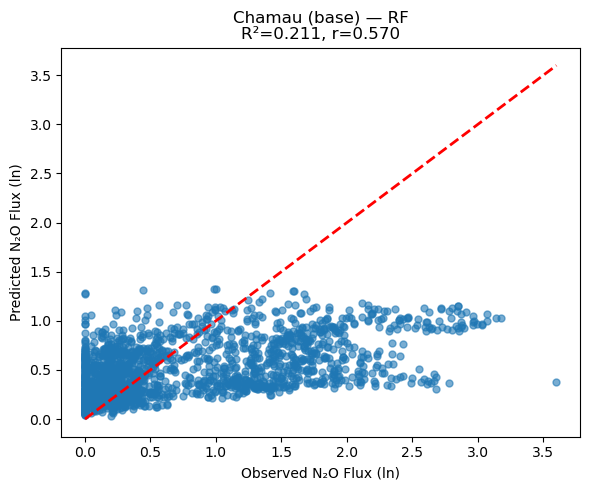


--- Chamau | predictors=lag ---
⚠️ Chamau missing 15 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau (lag): dropped 11788 rows (74.4%)


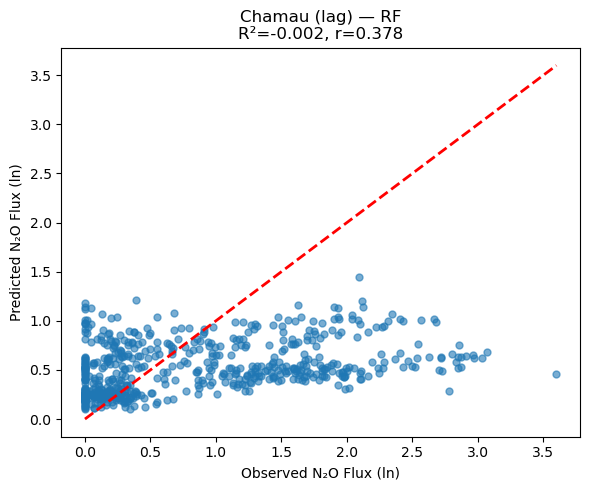


--- Chamau A | predictors=base ---
⚠️ Chamau A missing 3 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm']
📊 Chamau A (base): dropped 459 rows (8.4%)


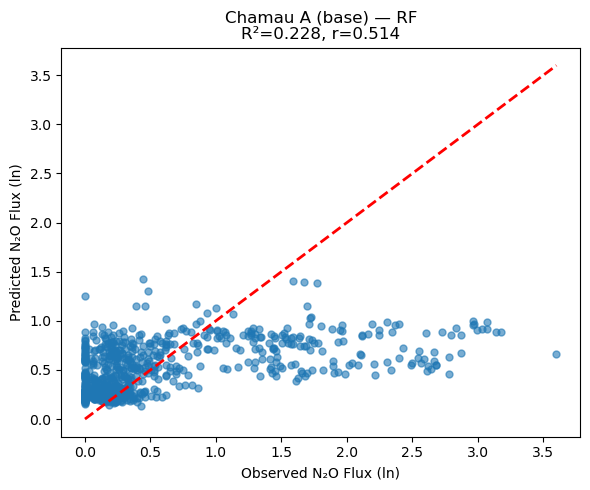


--- Chamau A | predictors=lag ---
⚠️ Chamau A missing 15 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau A (lag): dropped 4202 rows (76.9%)


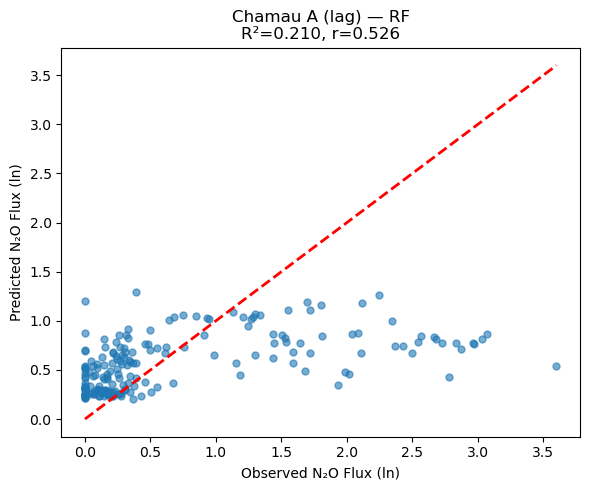


--- Chamau B | predictors=base ---
⚠️ Chamau B missing 3 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm']
📊 Chamau B (base): dropped 833 rows (8.0%)


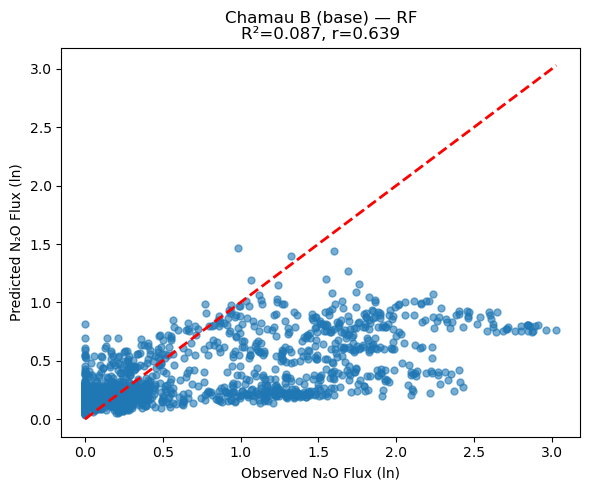


--- Chamau B | predictors=lag ---
⚠️ Chamau B missing 15 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau B (lag): dropped 7578 rows (73.2%)


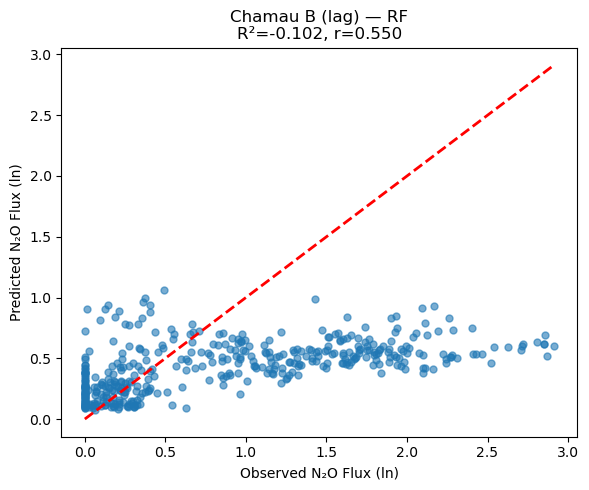


--- Aeschi | predictors=base ---
⚠️ Aeschi missing 5 predictors: ['FertilizerMineral', 'FertilizerOrganic', 'Grazing', 'SoilCultivation', 'SoilTemp_4cm']
📊 Aeschi (base): dropped 51 rows (2.8%)


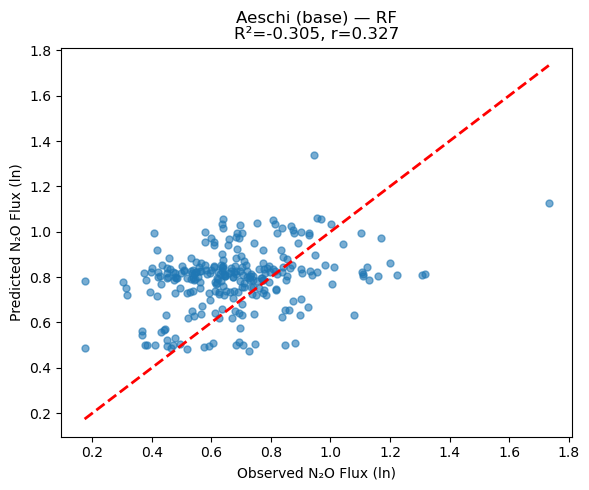


--- Aeschi | predictors=lag ---
⚠️ Aeschi missing 14 predictors: ['DaysSince_FertilizerMineral', 'DaysSince_FertilizerOrganic', 'DaysSince_Grazing', 'DaysSince_Mowing', 'DaysSince_SoilCultivation']...
📊 Aeschi (lag): dropped 610 rows (33.6%)


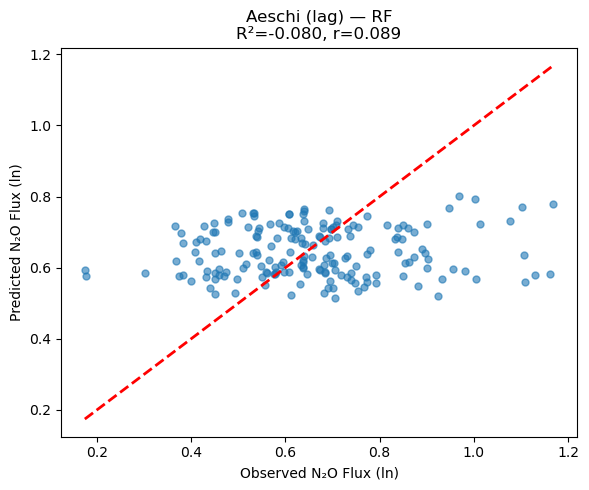


--- Oensingen 1 | predictors=base ---
⚠️ Oensingen 1 missing 2 predictors: ['Grazing', 'SoilTemp_4cm']
📊 Oensingen 1 (base): dropped 1406 rows (43.1%)


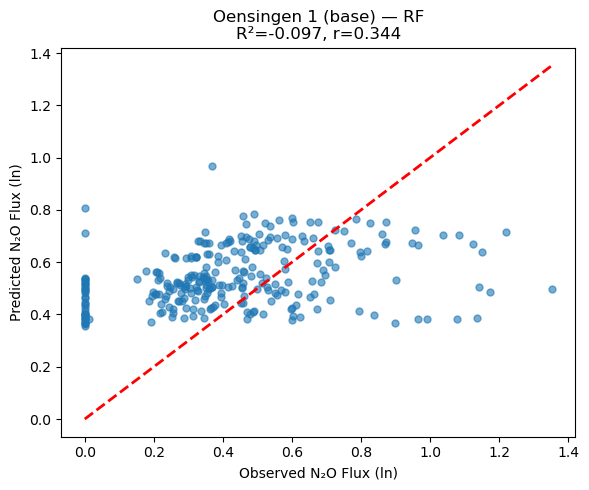


--- Oensingen 1 | predictors=lag ---
⚠️ Oensingen 1 missing 7 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...
📊 Oensingen 1 (lag): dropped 1741 rows (53.5%)


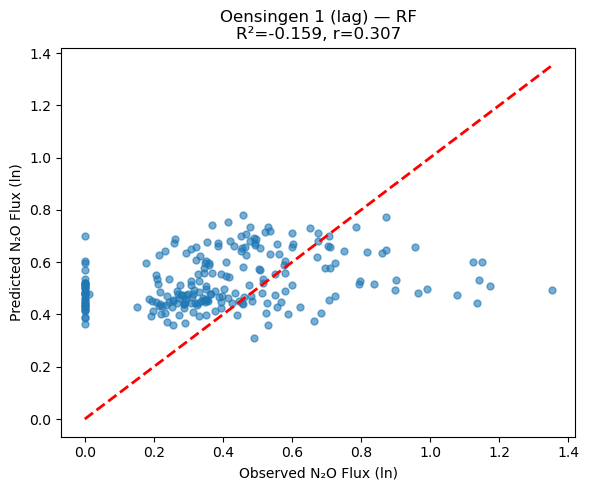


--- Oensingen 2 | predictors=base ---
⚠️ Oensingen 2 missing 2 predictors: ['Grazing', 'SoilTemp_4cm']
📊 Oensingen 2 (base): dropped 53 rows (0.8%)


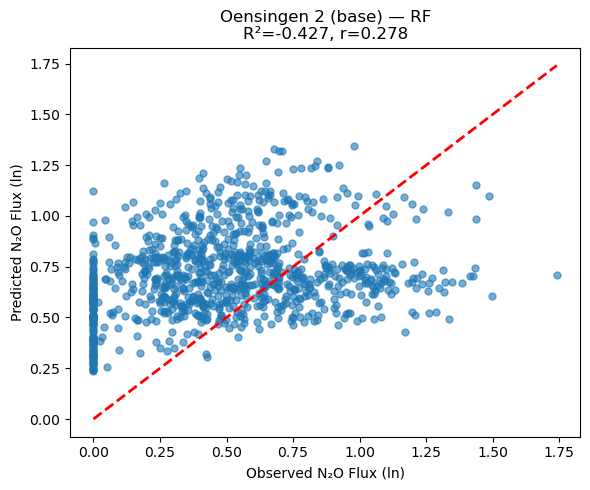


--- Oensingen 2 | predictors=lag ---
⚠️ Oensingen 2 missing 7 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...
📊 Oensingen 2 (lag): dropped 233 rows (3.5%)


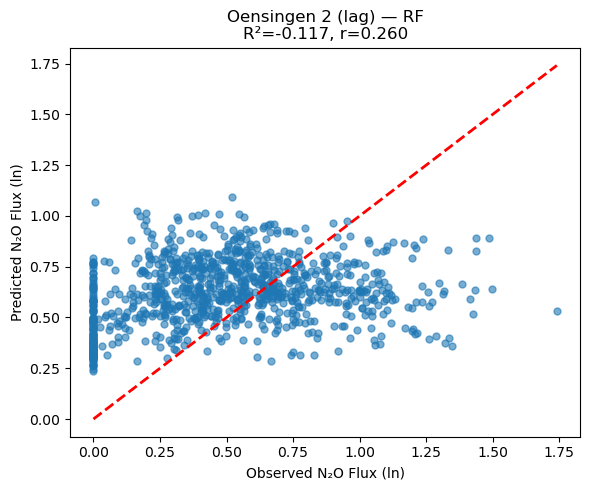

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = []

for name, df in datasets.items():
    for set_name, predictors in predictor_sets.items():
        print(f"\n--- {name} | predictors={set_name} ---")

        try:
            # --- Filter available predictors (same logic as ElasticNet) ---
            available_predictors = [p for p in predictors if p in df.columns]

            missing = set(predictors) - set(available_predictors)
            if missing:
                print(f"⚠️  {name} missing {len(missing)} predictors: "
                      f"{sorted(list(missing))[:5]}{'...' if len(missing) > 5 else ''}")

            if len(available_predictors) < 5:
                print(f"⚠️  Skipping {name} ({set_name}) — too few predictors left after filtering.")
                continue

            # --- Track NaN drops before training ---
            before_drop = len(df)
            df_clean = df.dropna(subset=available_predictors + [target])
            after_drop = len(df_clean)
            dropped = before_drop - after_drop
            pct_dropped = 100 * dropped / before_drop if before_drop > 0 else 0
            print(f"📊 {name} ({set_name}): dropped {dropped} rows "
                  f"({pct_dropped:.1f}% of total) due to NaNs")

            if after_drop < 50:
                print(f"⚠️  Skipping {name} ({set_name}) — not enough data after drop.")
                continue

            # --- Train Random Forest model ---
            res = train_rf_timeseries_simple(
                df_clean, available_predictors, target,
                date_col="Timestamp", pca=False
            )

            # --- Append metrics ---
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": round(res["r2"], 3),
                "Pearson_r": round(res["pearson_r"], 3) if np.isfinite(res["pearson_r"]) else None,
                "n_train": res["n_train"],
                "n_val": res["n_val"],
                "n_test": res["n_test"]
            })

            # --- Visualization section ---
            y_test = res["y_test"]
            y_pred = res["y_pred"]
            test_dates = res["test_dates"]

            # Skip degenerate cases
            if np.std(y_pred) < 1e-6 or np.std(y_test) < 1e-6:
                print(f"⚠️ {name} ({set_name}) → near-constant predictions or targets, skipping plot.")
                continue

            # --- Scatter plot (Predicted vs Observed) ---
            plt.figure(figsize=(6, 5))
            plt.scatter(y_test, y_pred, alpha=0.6, s=25)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.xlabel("Observed N₂O Flux (ln)")
            plt.ylabel("Predicted N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — RF\nR²={res['r2']:.3f}, r={res['pearson_r']:.3f}")
            plt.tight_layout()
            plt.show()

            # --- Time Series plot ---
            plt.figure(figsize=(10, 4))
            plt.plot(test_dates, y_test, label="Observed", color="black", lw=1.5)
            plt.plot(test_dates, y_pred, label="Predicted", color="forestgreen", lw=1.5, alpha=0.8)
            plt.xlabel("Date")
            plt.ylabel("N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — Random Forest Time Series")
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Skipped {name} ({set_name}) due to error: {e}")
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": None,
                "Pearson_r": None,
                "n_train": None,
                "n_val": None,
                "n_test": None
            })

# --- Final summary ---
results_df = pd.DataFrame(results).sort_values(by=["R²", "Pearson_r"], ascending=False)
display(results_df)


In [38]:
datasets = {
    "Chamau Daily": chamau_daily,
    "Chamau A Daily": chamau_daily_A,
    "Chamau B Daily": chamau_daily_B,
    "Aeschi Daily": aeschi_daily,
    "Oensingen Daily 1": oensingen_daily_1,
    "Oensingen Daily 2": oensingen_daily_2
}


--- Chamau Daily | predictors=base ---
⚠️  Chamau Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']
📊 Chamau Daily (base): dropped 163 rows (5.6% of total) due to NaNs


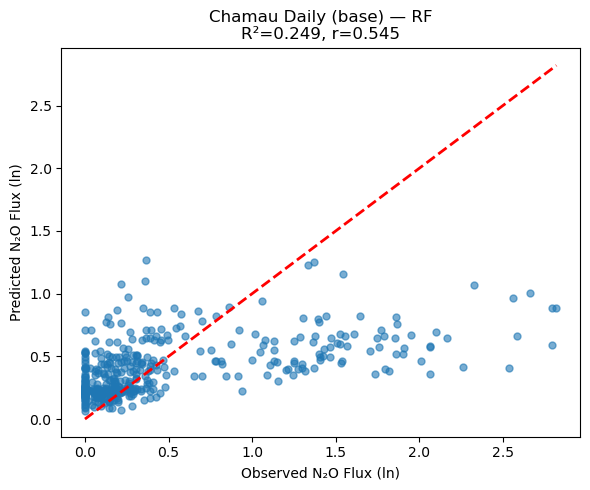

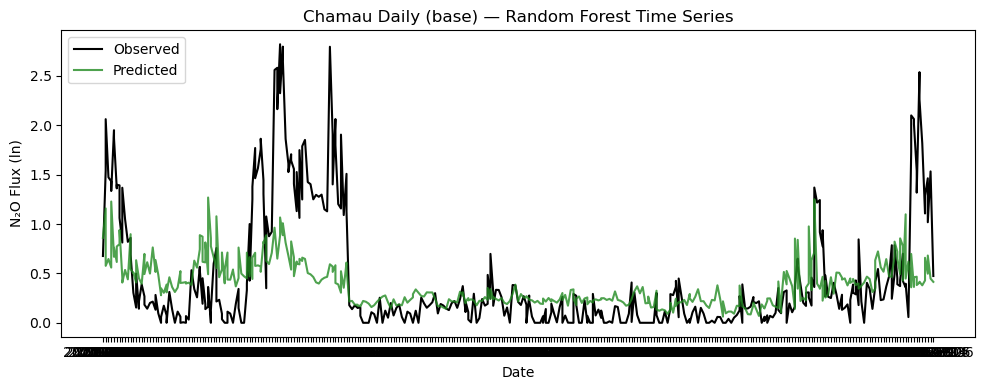


--- Chamau Daily | predictors=lag ---
⚠️  Chamau Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau Daily (lag): dropped 534 rows (18.4% of total) due to NaNs


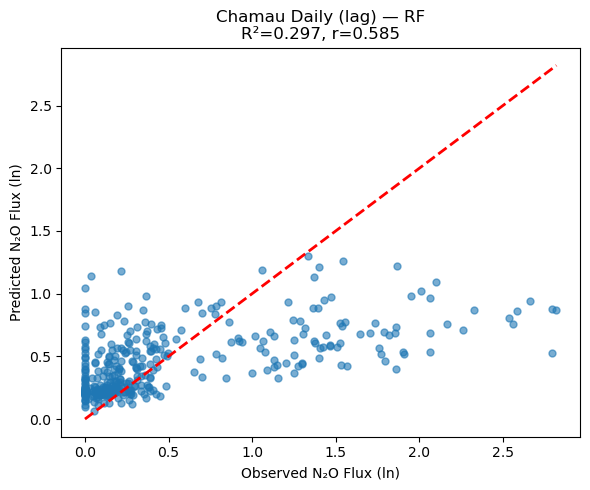

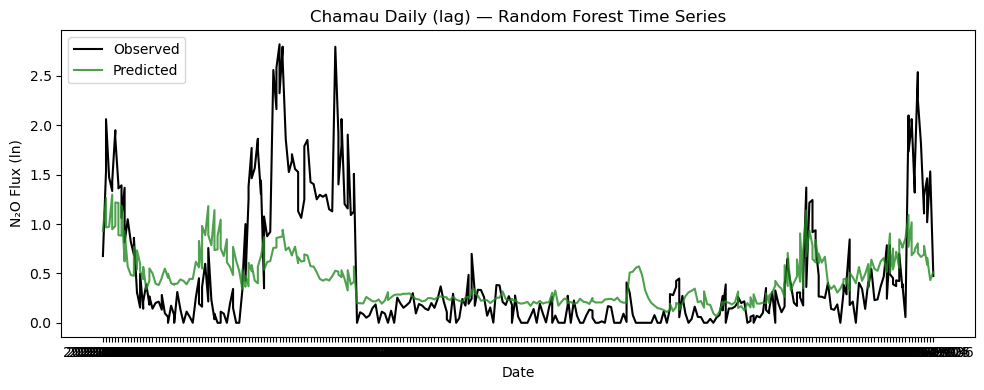


--- Chamau A Daily | predictors=base ---
⚠️  Chamau A Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']
📊 Chamau A Daily (base): dropped 70 rows (5.5% of total) due to NaNs


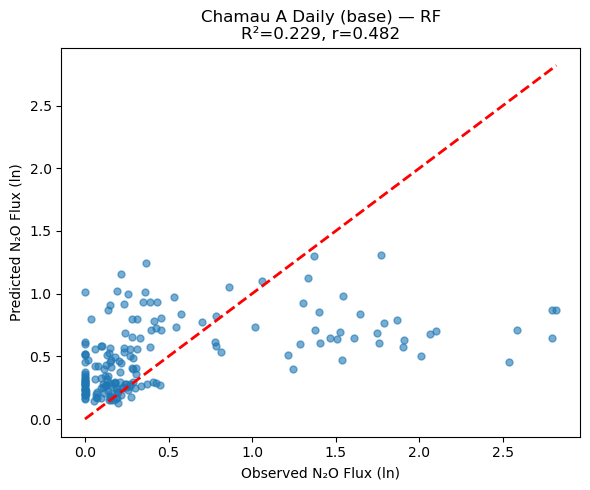

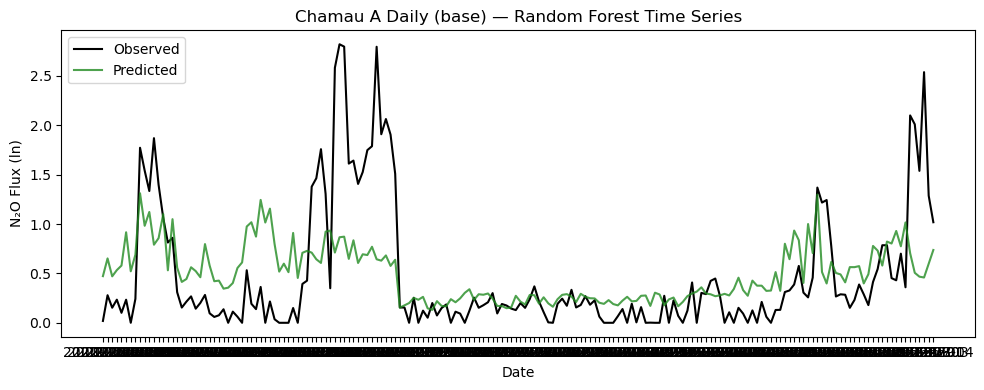


--- Chamau A Daily | predictors=lag ---
⚠️  Chamau A Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau A Daily (lag): dropped 248 rows (19.5% of total) due to NaNs


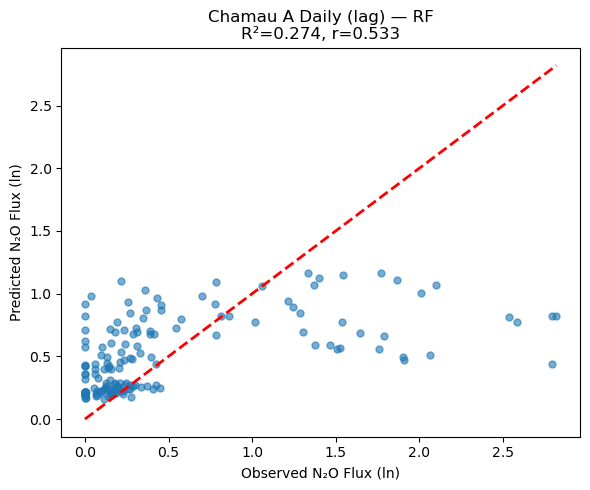

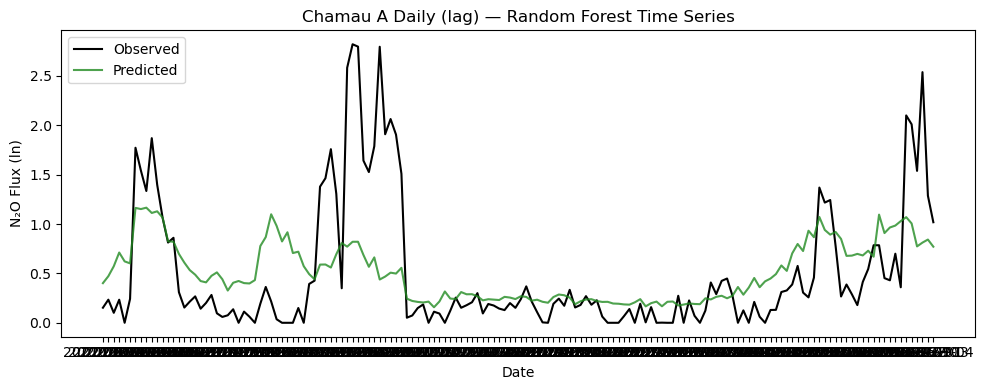


--- Chamau B Daily | predictors=base ---
⚠️  Chamau B Daily missing 5 predictors: ['SoilTemp_30cm', 'SoilTemp_5cm', 'SoilWater_30cm', 'day', 'hour']
📊 Chamau B Daily (base): dropped 93 rows (5.7% of total) due to NaNs


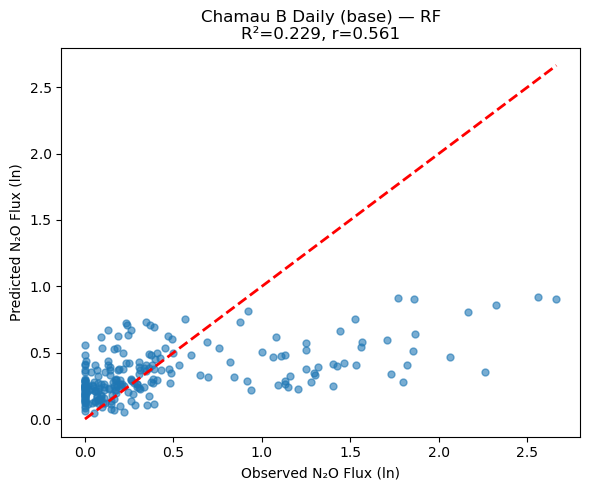

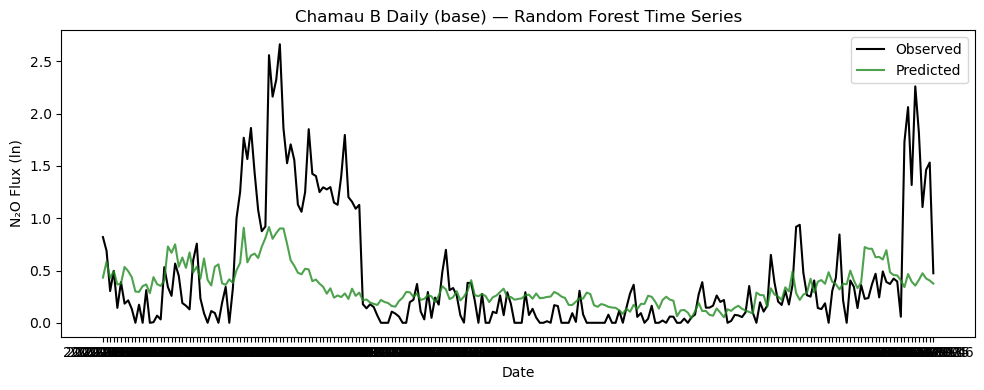


--- Chamau B Daily | predictors=lag ---
⚠️  Chamau B Daily missing 17 predictors: ['SoilTemp_30cm', 'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d']...
📊 Chamau B Daily (lag): dropped 286 rows (17.5% of total) due to NaNs


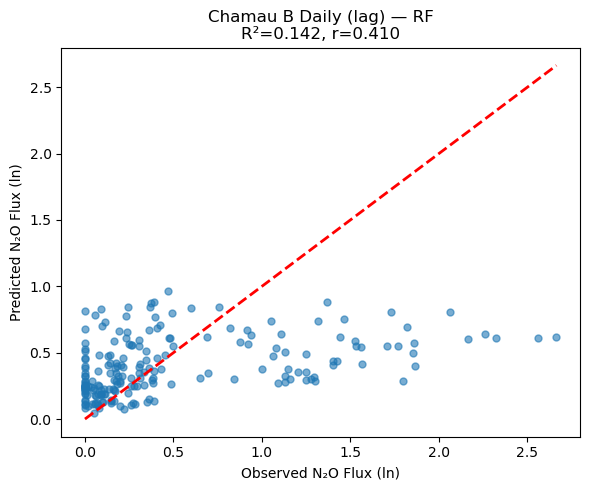

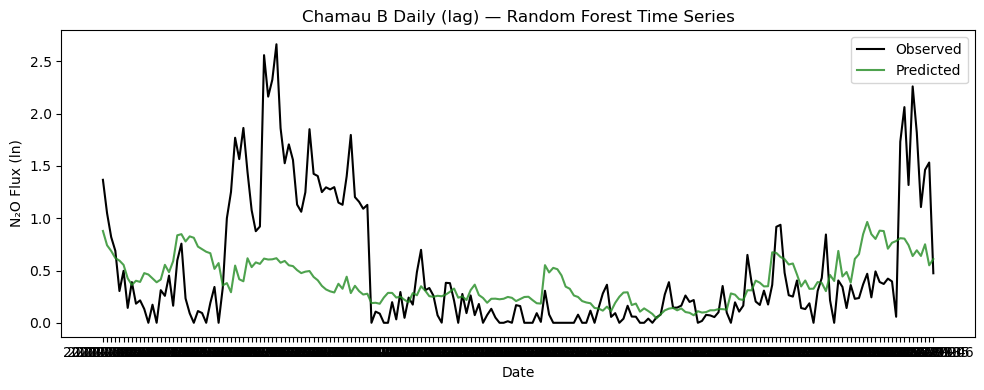


--- Aeschi Daily | predictors=base ---
⚠️  Aeschi Daily missing 7 predictors: ['FertilizerMineral', 'FertilizerOrganic', 'Grazing', 'SoilCultivation', 'SoilTemp_4cm']...
📊 Aeschi Daily (base): dropped 0 rows (0.0% of total) due to NaNs


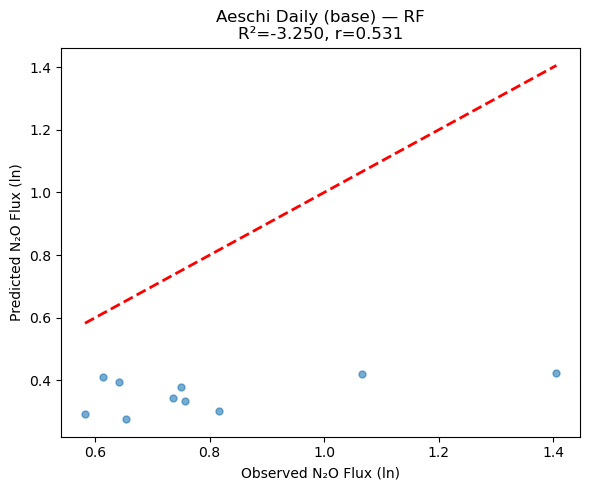

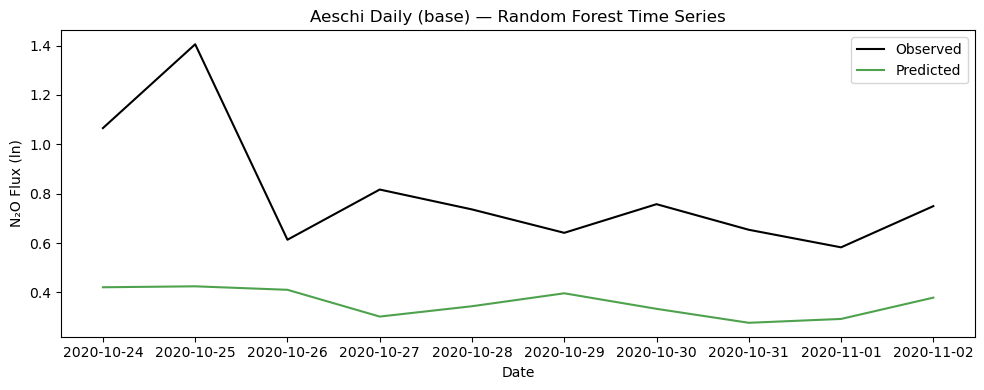


--- Aeschi Daily | predictors=lag ---
⚠️  Aeschi Daily missing 16 predictors: ['DaysSince_FertilizerMineral', 'DaysSince_FertilizerOrganic', 'DaysSince_Grazing', 'DaysSince_Mowing', 'DaysSince_SoilCultivation']...
📊 Aeschi Daily (lag): dropped 14 rows (20.9% of total) due to NaNs


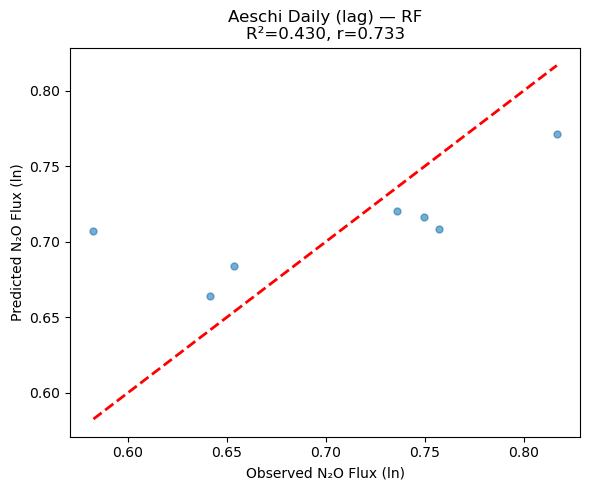

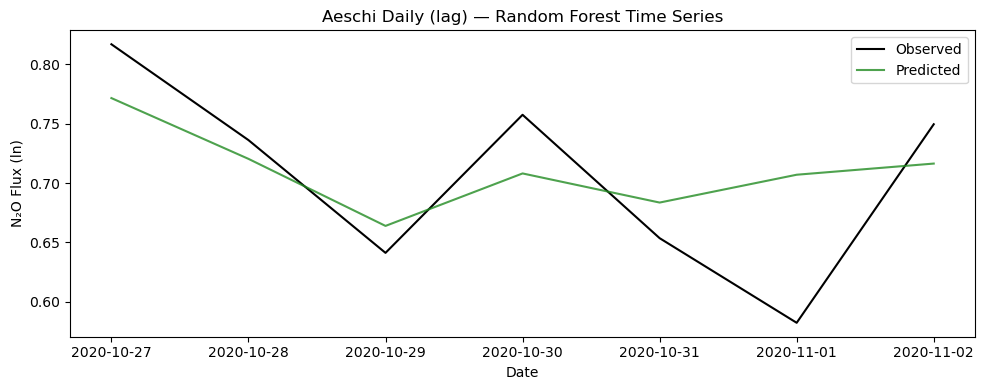


--- Oensingen Daily 1 | predictors=base ---
⚠️  Oensingen Daily 1 missing 4 predictors: ['Grazing', 'SoilTemp_4cm', 'day', 'hour']
📊 Oensingen Daily 1 (base): dropped 76 rows (46.1% of total) due to NaNs


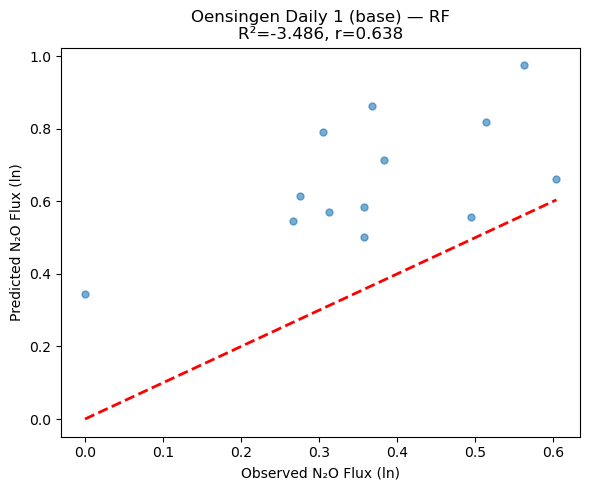

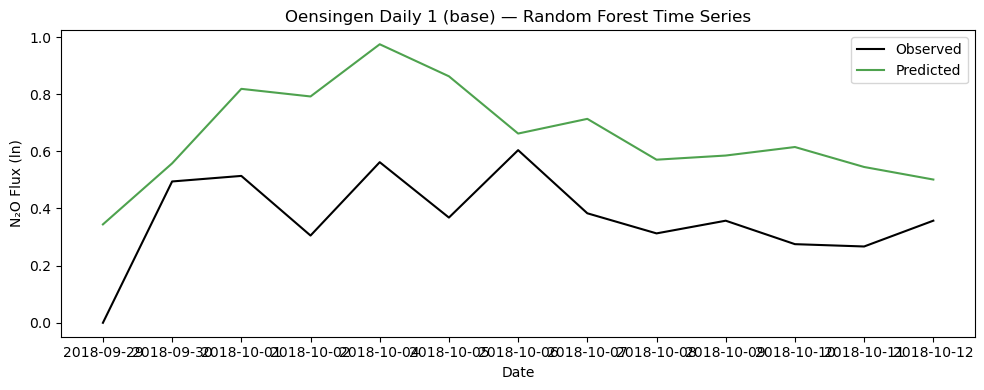


--- Oensingen Daily 1 | predictors=lag ---
⚠️  Oensingen Daily 1 missing 9 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...
📊 Oensingen Daily 1 (lag): dropped 94 rows (57.0% of total) due to NaNs


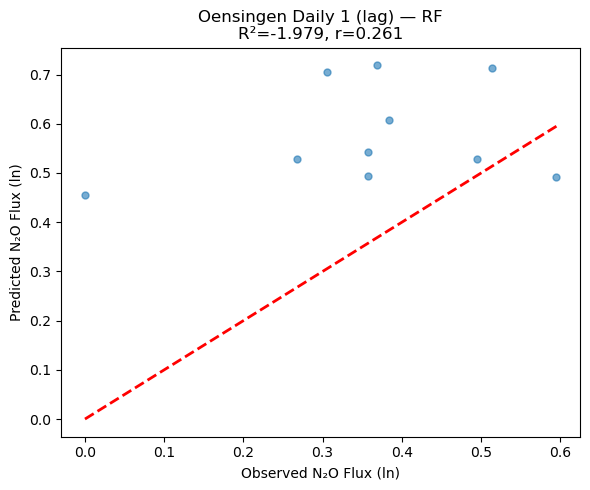

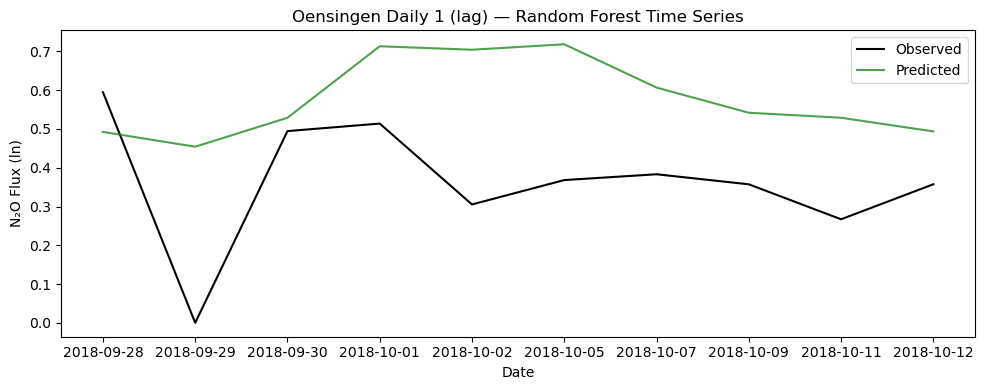


--- Oensingen Daily 2 | predictors=base ---
⚠️  Oensingen Daily 2 missing 4 predictors: ['Grazing', 'SoilTemp_4cm', 'day', 'hour']
📊 Oensingen Daily 2 (base): dropped 0 rows (0.0% of total) due to NaNs


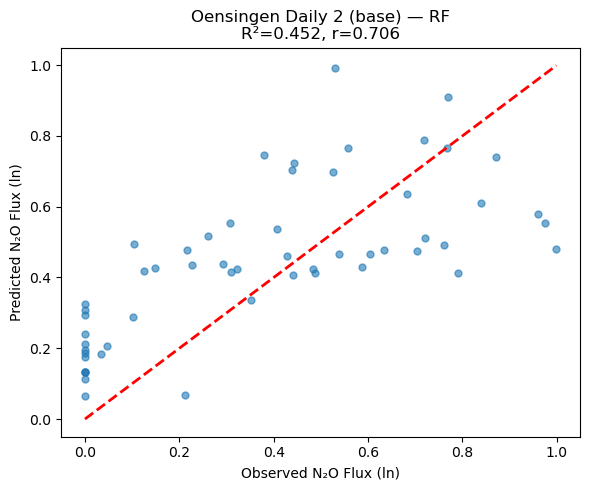

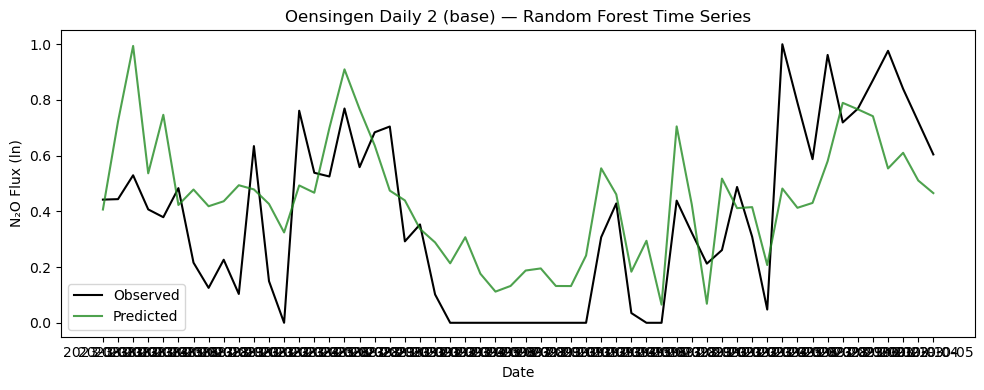


--- Oensingen Daily 2 | predictors=lag ---
⚠️  Oensingen Daily 2 missing 9 predictors: ['DaysSince_Grazing', 'Grazing', 'SoilTemp_4cm', 'SoilTemp_4cm_lag1d', 'SoilTemp_4cm_lag3d']...
📊 Oensingen Daily 2 (lag): dropped 57 rows (15.2% of total) due to NaNs


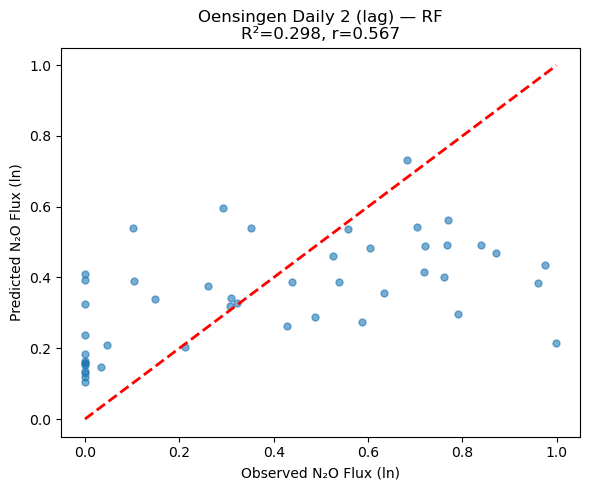

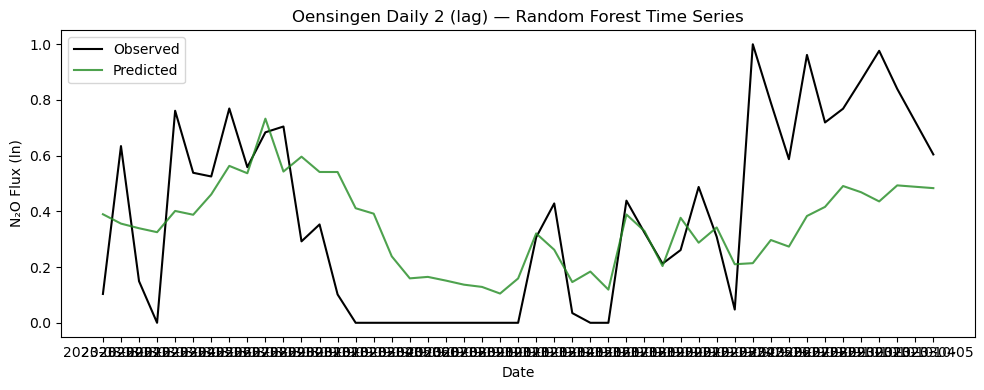

,Dataset,Predictor_Set,R²,Pearson_r,n_train,n_val,n_test
10,Oensingen Daily 2,base,0.452,0.706,262,56,56
7,Aeschi Daily,lag,0.430,0.733,39,7,7
11,Oensingen Daily 2,lag,0.298,0.567,223,47,47
1,Chamau Daily,lag,0.297,0.585,1662,356,356
3,Chamau A Daily,lag,0.274,0.533,719,154,154
0,Chamau Daily,base,0.249,0.545,1923,411,411
4,Chamau B Daily,base,0.229,0.561,1078,231,231
2,Chamau A Daily,base,0.229,0.482,845,180,180
5,Chamau B Daily,lag,0.142,0.410,943,202,202
9,Oensingen Daily 1,lag,-1.979,0.261,51,10,10


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = []

for name, df in datasets.items():
    for set_name, predictors in predictor_sets.items():
        print(f"\n--- {name} | predictors={set_name} ---")

        try:
            # --- Filter available predictors (same logic as ElasticNet) ---
            available_predictors = [p for p in predictors if p in df.columns]

            missing = set(predictors) - set(available_predictors)
            if missing:
                print(f"⚠️  {name} missing {len(missing)} predictors: "
                      f"{sorted(list(missing))[:5]}{'...' if len(missing) > 5 else ''}")

            if len(available_predictors) < 5:
                print(f"⚠️  Skipping {name} ({set_name}) — too few predictors left after filtering.")
                continue

            # --- Track NaN drops before training ---
            before_drop = len(df)
            df_clean = df.dropna(subset=available_predictors + [target])
            after_drop = len(df_clean)
            dropped = before_drop - after_drop
            pct_dropped = 100 * dropped / before_drop if before_drop > 0 else 0
            print(f"📊 {name} ({set_name}): dropped {dropped} rows "
                  f"({pct_dropped:.1f}% of total) due to NaNs")

            if after_drop < 50:
                print(f"⚠️  Skipping {name} ({set_name}) — not enough data after drop.")
                continue

            # --- Train Random Forest model ---
            res = train_rf_timeseries_simple(
                df_clean, available_predictors, target,
                date_col="Date", pca=False
            )

            # --- Append metrics ---
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": round(res["r2"], 3),
                "Pearson_r": round(res["pearson_r"], 3) if np.isfinite(res["pearson_r"]) else None,
                "n_train": res["n_train"],
                "n_val": res["n_val"],
                "n_test": res["n_test"]
            })

            # --- Visualization section ---
            y_test = res["y_test"]
            y_pred = res["y_pred"]
            test_dates = res["test_dates"]

            # Skip degenerate cases
            if np.std(y_pred) < 1e-6 or np.std(y_test) < 1e-6:
                print(f"⚠️ {name} ({set_name}) → near-constant predictions or targets, skipping plot.")
                continue

            # --- Scatter plot (Predicted vs Observed) ---
            plt.figure(figsize=(6, 5))
            plt.scatter(y_test, y_pred, alpha=0.6, s=25)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.xlabel("Observed N₂O Flux (ln)")
            plt.ylabel("Predicted N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — RF\nR²={res['r2']:.3f}, r={res['pearson_r']:.3f}")
            plt.tight_layout()
            plt.show()

            # --- Time Series plot ---
            plt.figure(figsize=(10, 4))
            plt.plot(test_dates, y_test, label="Observed", color="black", lw=1.5)
            plt.plot(test_dates, y_pred, label="Predicted", color="forestgreen", lw=1.5, alpha=0.8)
            plt.xlabel("Date")
            plt.ylabel("N₂O Flux (ln)")
            plt.title(f"{name} ({set_name}) — Random Forest Time Series")
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Skipped {name} ({set_name}) due to error: {e}")
            results.append({
                "Dataset": name,
                "Predictor_Set": set_name,
                "R²": None,
                "Pearson_r": None,
                "n_train": None,
                "n_val": None,
                "n_test": None
            })

# --- Final summary ---
results_df = pd.DataFrame(results).sort_values(by=["R²", "Pearson_r"], ascending=False)
display(results_df)
